In [4]:
import os
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
%matplotlib inline
from pyspark.sql import Row, SparkSession
from pyspark.sql.functions import *

In [6]:
path = "data/"
file_name = ['chicago_2019.csv', 'chicago_2020.csv', 'chicago_2021.csv', 'chicago_2022.csv']
filenames =[path + file for file in file_name]
#print(filenames)

""" 
    Read Me: Basic File Merger, to combine the 2019-2022 census data
    Requires: file path list
"""
def fileMerger(path):
    df1 = pd.read_csv(path[0])
    df2 = pd.read_csv(path[1])
    df_merged = df1.merge(df2, how='outer')
    for file in path[2:]:
        temp = pd.read_csv(file)
        df_merged = df_merged.merge(temp, how='outer')
    return df_merged

df = fileMerger(filenames)

In [7]:
df.shape

(922148, 22)

In [8]:
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,24368,JC103046,01/03/2019 02:37:00 PM,050XX S INDIANA AVE,0110,HOMICIDE,FIRST DEGREE MURDER,AUTO,False,False,...,3.0,38.0,01A,1178455.0,1871575.0,2019,09/01/2022 03:42:17 PM,41.802909,-87.621048,"(41.802908524, -87.62104831)"
1,24369,JC103046,01/03/2019 02:37:00 PM,050XX S INDIANA AVE,0110,HOMICIDE,FIRST DEGREE MURDER,AUTO,False,False,...,3.0,38.0,01A,1178455.0,1871575.0,2019,09/01/2022 03:42:17 PM,41.802909,-87.621048,"(41.802908524, -87.62104831)"
2,24370,JC105864,01/05/2019 04:23:00 PM,012XX N ADA ST,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,...,2.0,24.0,01A,1167119.0,1908611.0,2019,09/01/2022 03:42:17 PM,41.904789,-87.661560,"(41.904788891, -87.66155984)"
3,24371,JC106397,01/06/2019 12:10:00 AM,014XX W 71ST PL,0110,HOMICIDE,FIRST DEGREE MURDER,APARTMENT,True,False,...,17.0,67.0,01A,1168078.0,1857336.0,2019,09/19/2022 03:41:05 PM,41.764065,-87.659515,"(41.764064647, -87.659514616)"
4,24372,JC107385,01/06/2019 10:23:00 PM,060XX W 63RD ST,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,...,13.0,64.0,01A,1137054.0,1862130.0,2019,09/01/2022 03:42:17 PM,41.777831,-87.773112,"(41.77783091, -87.773112387)"


In [9]:
# Converting Community Area Code to an Community Name
"""
This allows us to explore data much effectively, being able
to scrape further information outside of just a code, such as
exploring real estate property indices in each community, and
make inferences regarding average home sale price and its corresponding community.
"""
import requests
url = "https://www.chicagotribune.com/2002/12/04/chicago-communities-17/"
text = requests.get(url).text

In [10]:
tables = pd.read_html(url)
print("Found {} tables in {}".format(len(tables), url))

Found 4 tables in https://www.chicagotribune.com/2002/12/04/chicago-communities-17/


In [11]:
hash = {"Community Area" : ["nan", "nan"], "Community Name": ["NaN", "NaN"]}

In [12]:
community = tables[1]

for item in (community):
    # community index
    if(item == 0 or item == 2):
        for i in range(len(community[item])):
                community[item] = community[item].astype(float)
                hash['Community Area'].append(community[item][i])
    if(item == 1 or item == 3):
        for i in range(len(community[item])):
                community[item] = community[item].astype(str)
                #print(community[item][i])
                hash['Community Name'].append(community[item][i])


In [13]:
def applyName(x):
    for item in range(len(hash["Community Area"])):
        if x == hash["Community Area"][item]:
            return hash["Community Name"][item]
df["Community Name"] = df['Community Area'].apply(applyName)

In [14]:
import geopandas
from shapely.geometry import Point

In [15]:
df['geometry'] = df.apply(lambda x: Point(x['X Coordinate'], x['Y Coordinate']), axis=1)

In [16]:
# temp df will serve as temporary alternative to df, to be able to conduct the without location data graphical analysis,
# hence, we will not be dropping any NaNs from the dataset for the sake of visualization.
temp = df.copy(deep=True)

# main df will remain 
df = df.dropna(subset=["Longitude", "Latitude", "Ward", "Community Area", "Location Description"])
df = df[(df['Longitude'] > -88) & (df['Longitude'] < -87) & (df['Latitude'] > 41) & (df['Latitude'] < 43)]

In [17]:
## for analysis purposes, conduct smaller analysis, let's run only 2019
df2019 = df[df['Year'] == 2019]
df2020 = df[df['Year'] == 2020]
df2021 = df[df['Year'] == 2021]
df2022 = df[df['Year'] == 2022]

In [18]:
policing_sf = geopandas.GeoDataFrame(df2019, geometry="geometry")
policing_sf.crs = {"init": "epsg:4326"}

# establish shape file
sf = geopandas.read_file('chicago_zip.geojson')
sf.crs = {'init' : 'epsg:4326'}
sf = sf.set_geometry('geometry')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [19]:
df2019 = geopandas.tools.sjoin(policing_sf, sf, how='left')

# Time Series # 
For the sake of conducting some potential regarding time series, in my project, I decided to set up a sepatate dataframe that will set the dataframe's index to each case's respective date-time variable. 

In [20]:
df_time = temp.copy(deep=True)
df_time.index = pd.DatetimeIndex(df_time.Date)

In [21]:
df_time['Day'] = df_time.index
df_time['Month'] = df_time.index.month
df_time['DayOfWeek'] = df_time.index.dayofweek
df_time['DayOfMonth'] = df_time.index.day
df_time['DayOfYear'] = df_time.index.dayofyear
df_time['WeekOfMonth'] = df_time.DayOfMonth.apply(lambda x: (x-1) // 7+1)
df_time = df_time.sort_index(ascending=True)

In [22]:
import math
dayOfYear = list(df_time.index.dayofyear)
weekOfYear = [math.ceil(x / 7) for x in dayOfYear]
df_time['weekOfYear'] = weekOfYear

<function matplotlib.pyplot.show(close=None, block=None)>

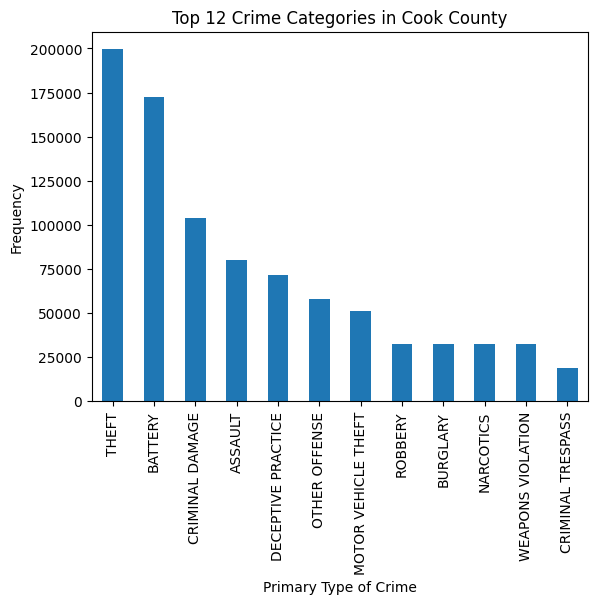

In [23]:
df_time['Primary Type'].value_counts().head(12).plot.bar()
plt.title("Top 12 Crime Categories in Cook County")
plt.xlabel("Primary Type of Crime")
plt.ylabel("Frequency")
plt.show

<details>


We can clearly observe that crime categorized as "THEFT" has the highest occurences in Chicago, Cook County. The bar chart presents a  visual summarization of crime frequency distribution across distinct categories within Cook County (total of all districts). Notably, the taxonomy of crime reveals a pronounced prevalence of theft-related incidents, which conspicuously surpasses other categories, indicating it as the most exigent issue within the dataset. Following theft, the incidences of battery and criminal damage constitute the subsequent tiers of frequency, thereby suggesting a potential correlation between property crimes and violent offenses within this jurisdiction. The graphical representation delineates a right-skewed distribution of crime frequencies, with a steep decline observed as one progresses from the most to the least common offenses. This skewness could be reflective of the underlying social, economic, and environmental factors that disproportionately elevate certain crime rates. The lesser frequent categories, such as narcotics and criminal trespass, despite their position on the graph, still represent significant concerns and warrant focused analytical attention to understand their lower relative frequencies. Inter-category comparison shows a notable variance in frequency, which may invite a hypothesis that the underlying causes of these crimes have different rates of incidence or reporting within the community. The disparity in the magnitude of occurrences also raises inquiries into the effectiveness of law enforcement and preventative measures tailored to each crime category. Moreover, the visual data underscores the necessity for a multifaceted approach to crime prevention and resource allocation. Policymakers and law enforcement could leverage such a data-driven perspective to optimize strategies that address the most prevalent crimes, without neglecting the lower frequency but equally impactful crime types.

</details>

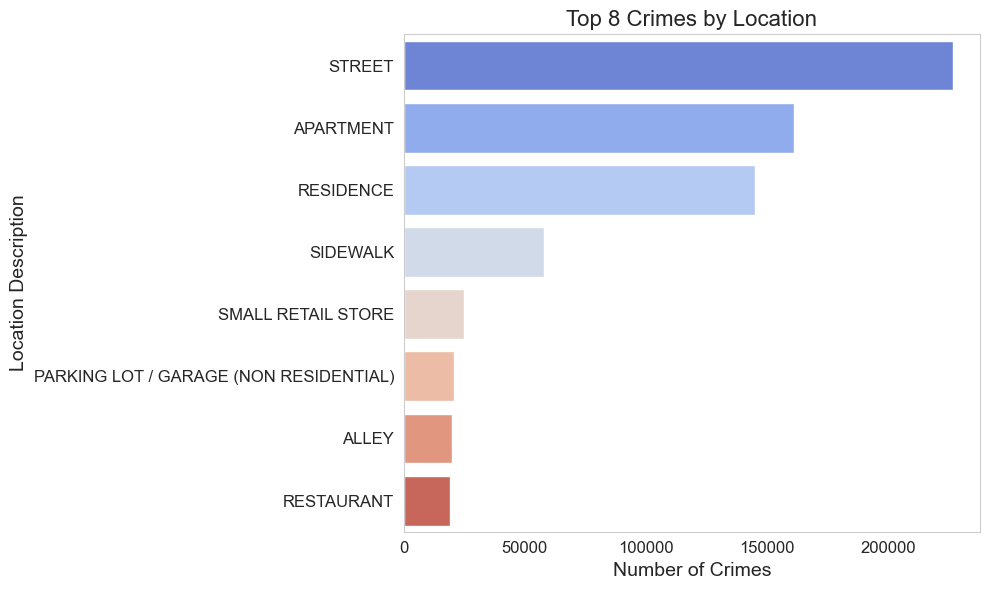

In [24]:
top_locations = df_time['Location Description'].value_counts().head(8)
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
palette = sns.color_palette("coolwarm", len(top_locations))
sns.barplot(x=top_locations.values, y=top_locations.index, palette=palette)
# Customize the visualization
plt.title('Top 8 Crimes by Location', fontsize=16)
plt.xlabel('Number of Crimes', fontsize=14)
plt.ylabel('Location Description', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

Crimes are most frequently occuring in areas of residence within Chicago, Cook County. There could potentially be an observable correlation between crimes occuring within domestic cases, rather than by random occurence. Might look into investigating. 

In [25]:
def bar_plot(data, col):
    if data[col].dtype in ['object']:
        fig, ((axis1, axis2)) = plt.subplots(2, 1, figsize=(15,20))
        plot = df[['Arrest', col]].dropna()
        df1 = plot.loc[plot['Arrest'] == True]
        df2 = plot.loc[plot['Arrest'] == False]
        df1.groupby(col)[col].count().nlargest(10).plot(kind='barh', ax=axis1, title='Arrest: ' + col) 
        df2.groupby(col)[col].count().nlargest(10).plot(kind='barh', ax=axis2, title='NO Arrest: ' + col) 


In [26]:
def bar_plot(df, col, title_prefix=''):
    
    # CHECK TO SEE IF THE COLUMN IS PRESENT >> 
    if col in df.columns and df[col].dtype == 'object':
        plot_data = df[['Arrest', col]].dropna()
        sns.set_style("whitegrid")
        fig, axes = plt.subplots(2, 1, figsize=(10, 12))
        for i, arrest_status in enumerate([True, False]):
            temp_df = plot_data[plot_data['Arrest'] == arrest_status]
            count_series = temp_df[col].value_counts().nlargest(10)
            palette = sns.color_palette("rocket", len(count_series))
            sns.barplot(y=count_series.index, x=count_series.values, ax=axes[i], palette=palette)
            axes[i].set_title(f"{title_prefix}{'Yes Arrest' if arrest_status else 'No Arrest'}: {col}")
            axes[i].set_xlabel('Count')
            axes[i].set_ylabel(col)
        plt.tight_layout()
        plt.show()

    else:
        print(f"Column '{col}' is not present or not categorical.")


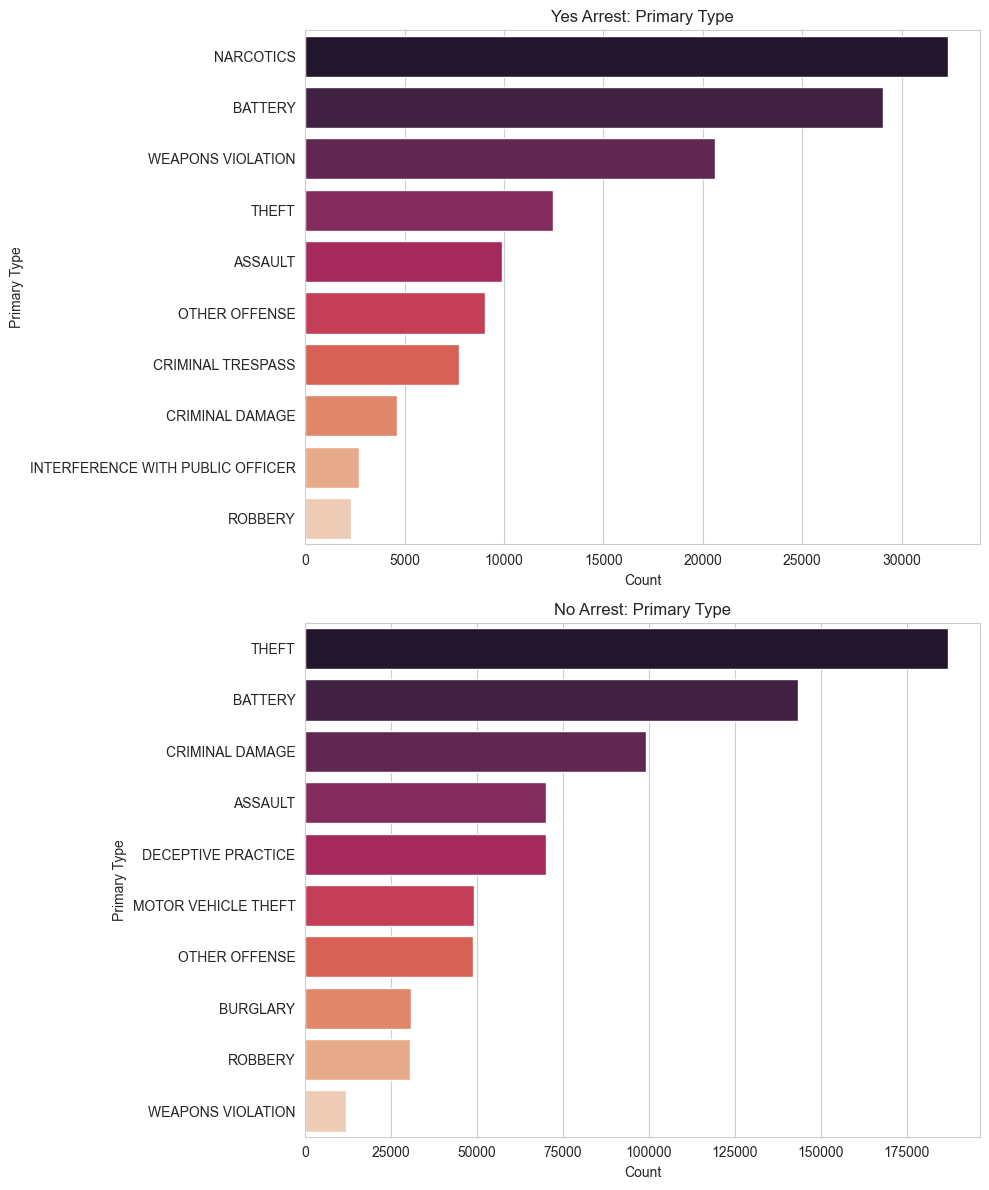

In [27]:
bar_plot(df_time, 'Primary Type')

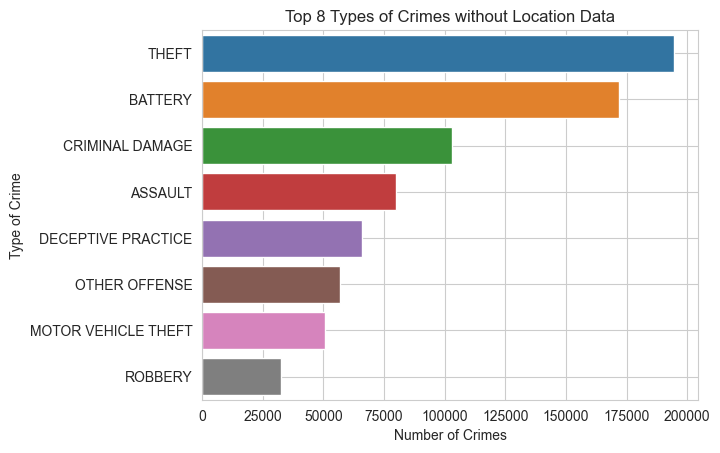

In [28]:
is_crimes = df_time[df_time["Location"].notnull()]
crime_counts = is_crimes.groupby("Primary Type").size().sort_values(ascending=False).head(8)
crime_counts_df = crime_counts.reset_index(name='Number of Crimes')
fig = sns.barplot(x="Number of Crimes", y="Primary Type", data=crime_counts_df)
plt.title("Top 8 Types of Crimes without Location Data")
plt.xlabel("Number of Crimes")
plt.ylabel("Type of Crime")
plt.grid(True)
plt.show()

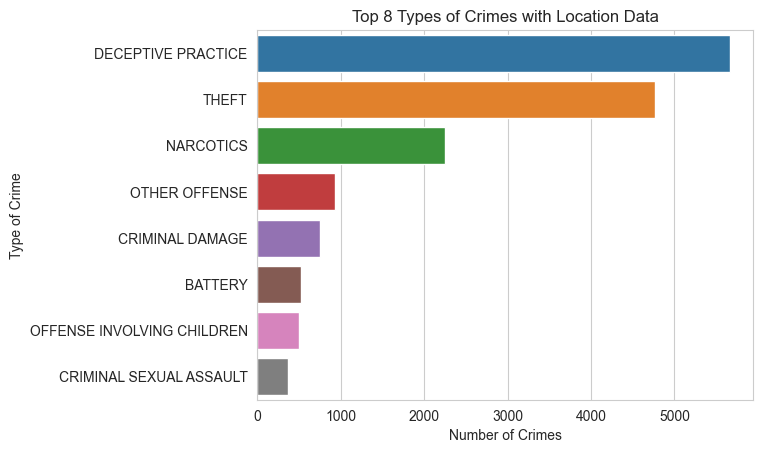

In [29]:
not_crime = df_time[df_time["Location"].isnull()]
crime_counts = not_crime.groupby("Primary Type").size().sort_values(ascending=False).head(8)
crime_counts_df = crime_counts.reset_index(name='Number of Crimes')
fig = sns.barplot(x="Number of Crimes", y="Primary Type", data=crime_counts_df)
plt.title("Top 8 Types of Crimes with Location Data")
plt.xlabel("Number of Crimes")
plt.ylabel("Type of Crime")
plt.show()

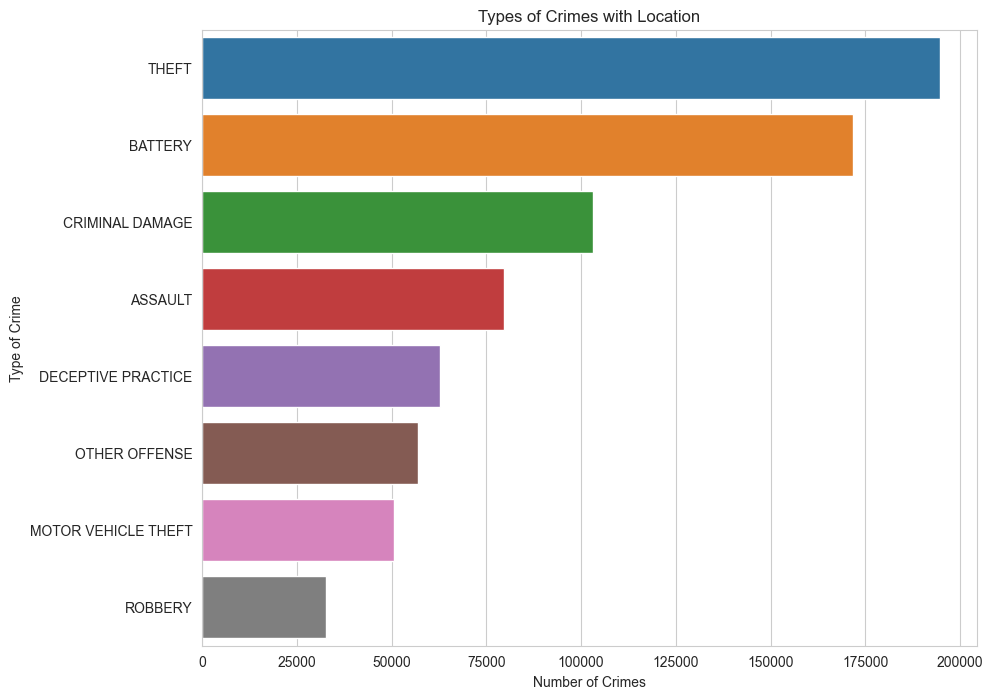

In [30]:
not_crime = df[df["Location"].isnull()==False]
not_crime = df[df["Location"].isnull()==False]
not_crime = not_crime.groupby("Primary Type").size().sort_values(ascending=False).reset_index(name='counts').head(8)
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size as needed
sns.barplot(data=not_crime, y="Primary Type", x="counts", ax=ax)
plt.title("Types of Crimes with Location")
plt.xlabel("Number of Crimes")
plt.ylabel("Type of Crime")
plt.show()

* Deceptive Practice
It's the crime where a person commits a practice when they have the intent to defraud another person and does any of the follow:
- Knowingly cause another person, by threat or deception, to execute a document/payment
- Dispose the victim of a property or incur a pecuniary oblogation
> This in turn makes sense, that it wouldn't have a location, given that most of these crimes are reported through online documentation, an idea would be that the crime occurs in wards with an higher overall income, who may be more suspect to being targeted by these fraudulent malpractices. 

In [31]:
df['Y Coordinate']

0         1871575.0
1         1871575.0
2         1908611.0
3         1857336.0
4         1862130.0
            ...    
921746    1857928.0
921762    1911884.0
921769    1950202.0
921778    1915651.0
921862    1904497.0
Name: Y Coordinate, Length: 901391, dtype: float64

Text(0.5, 1.0, 'Crime Distribution per District')

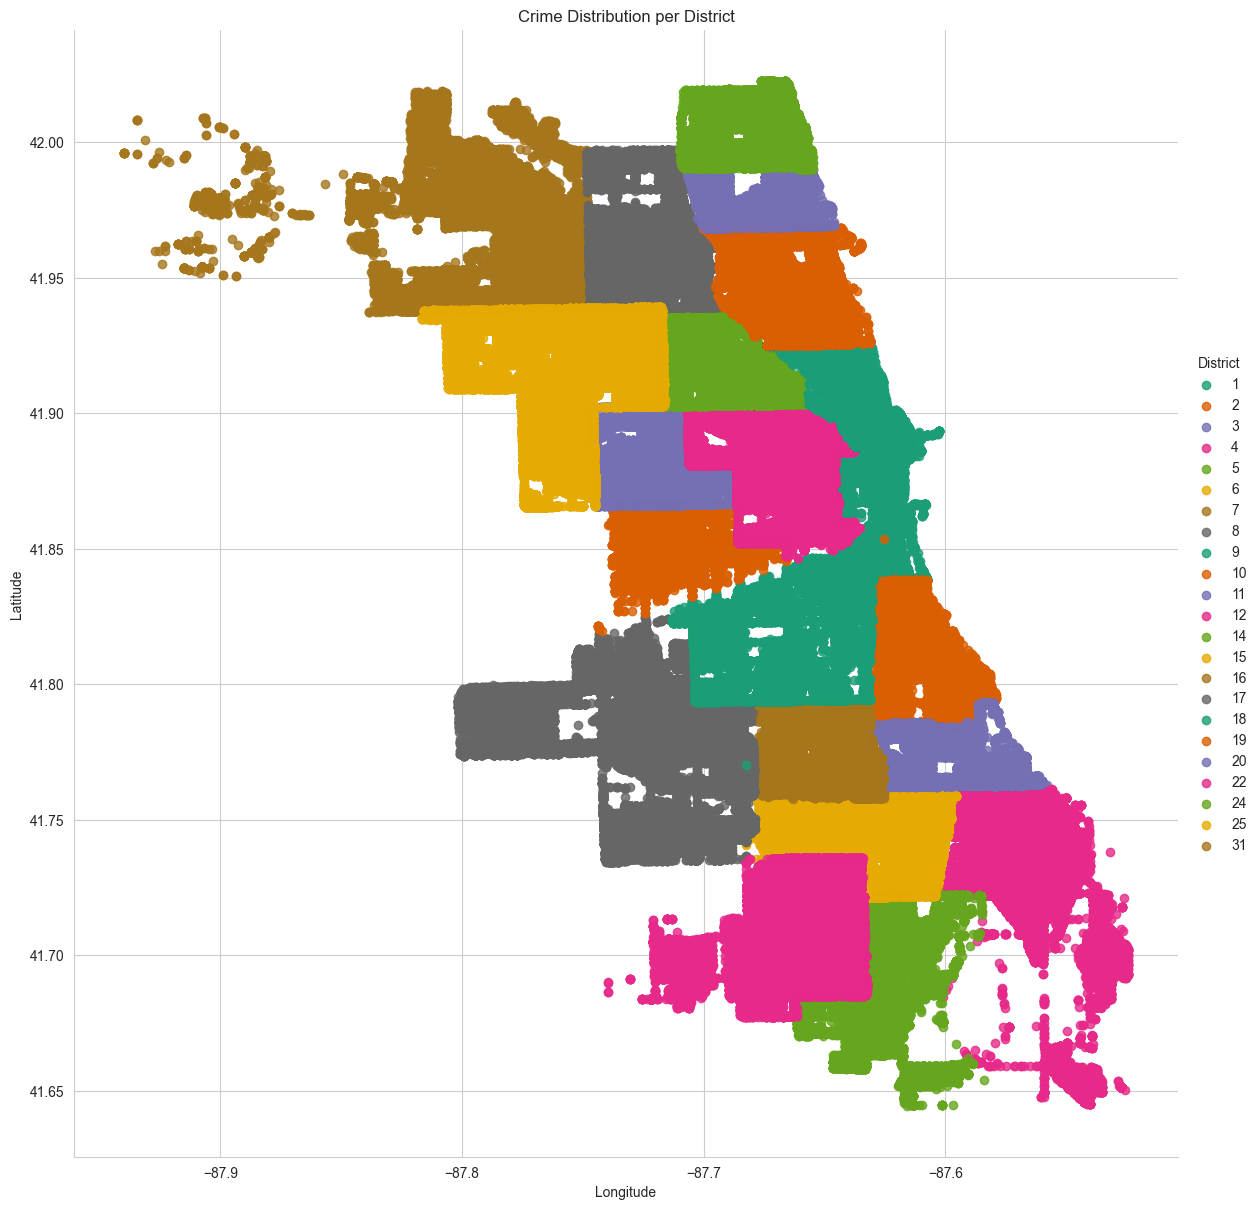

In [32]:
filtered_df = df[(df['Longitude'] > -88) & (df['Longitude'] < -87) & (df['Latitude'] > 41) & (df['Latitude'] < 43)]
sns.lmplot(data=filtered_df, 
           x= 'Longitude', 
           y= 'Latitude',
           fit_reg=False,
           hue="District",
           palette='Dark2',
           height=12,
           ci=2)
ax = plt.gca()
ax.set_title("Crime Distribution per District")

Text(0.5, 1.0, 'Crime Distribution per Community Name')

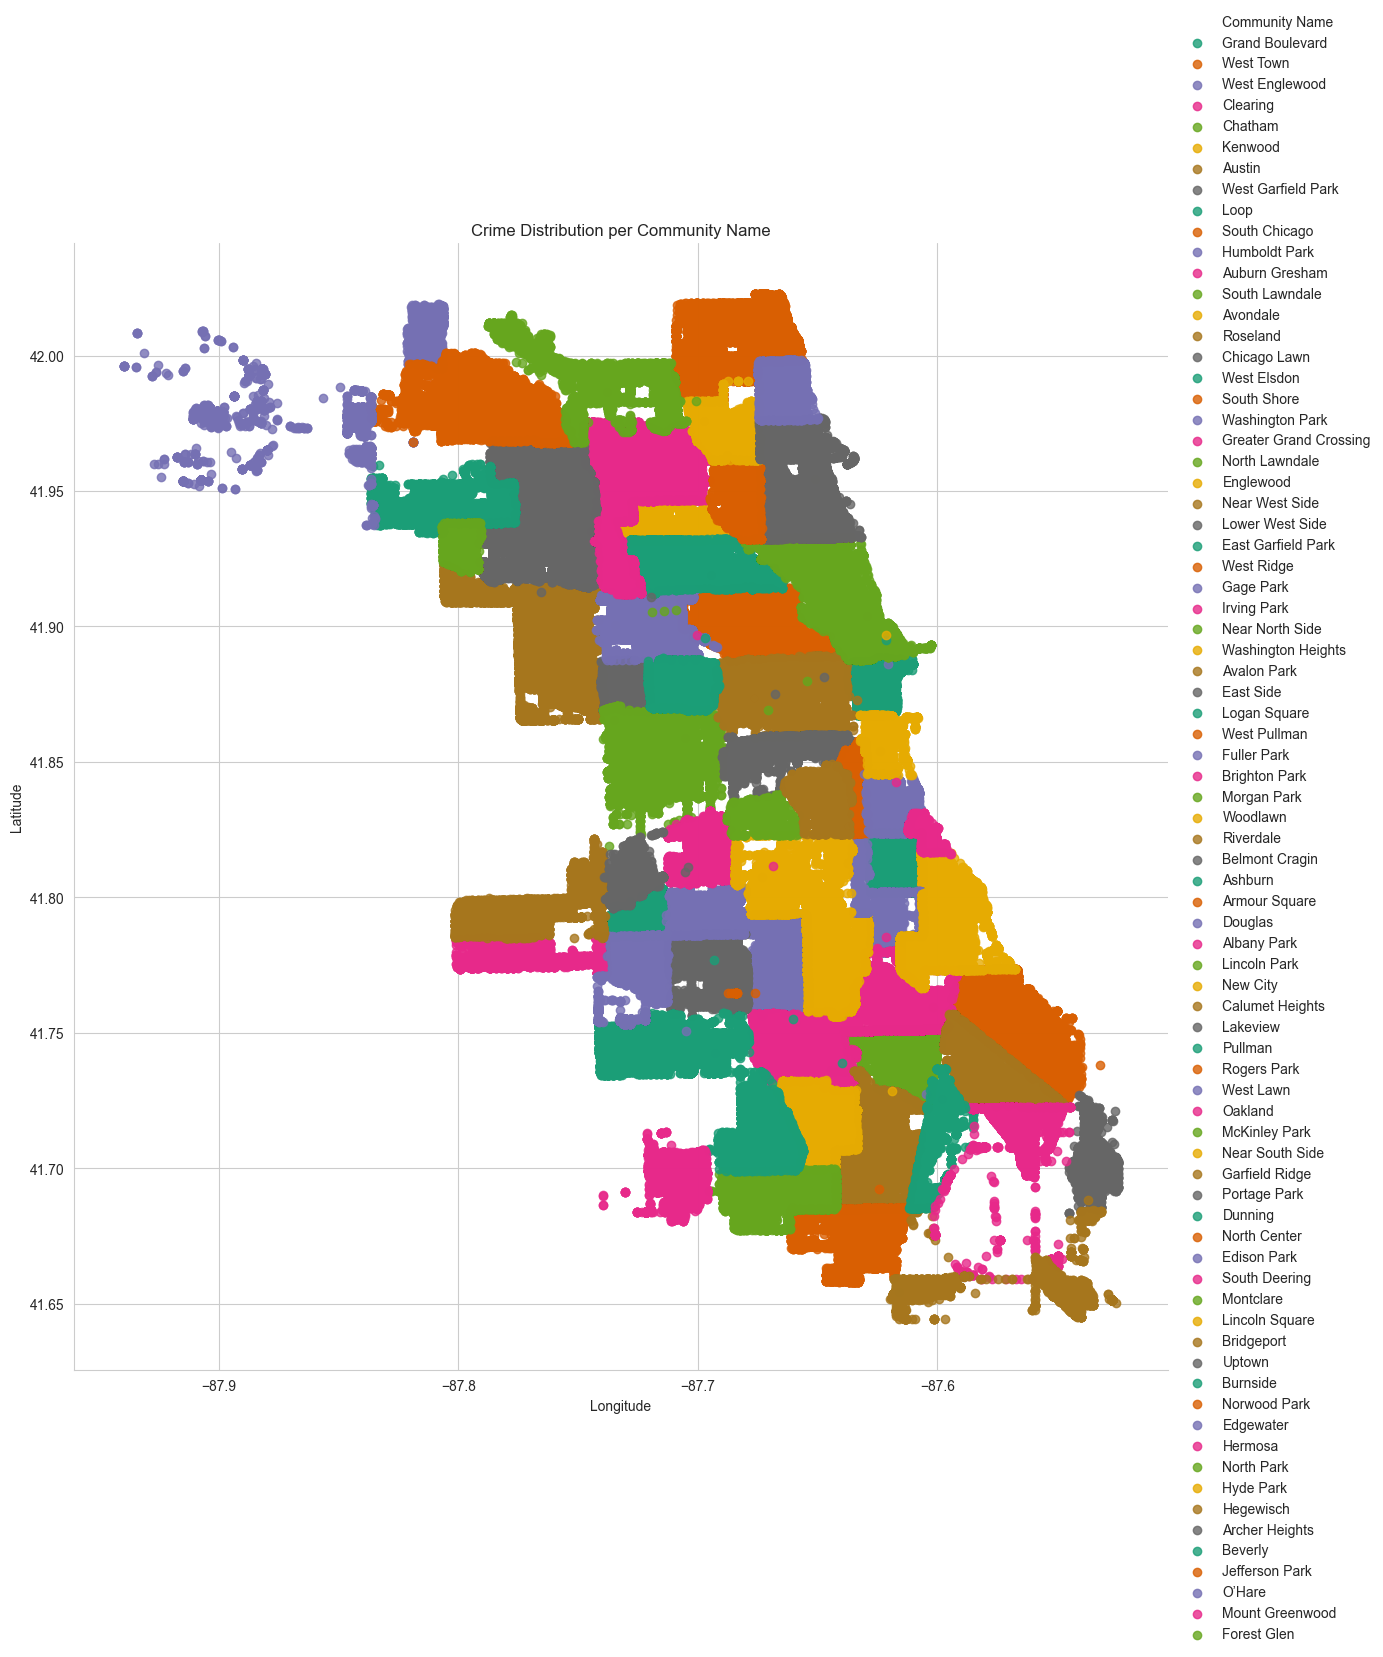

In [33]:
filtered_df = df[(df['Longitude'] > -88) & (df['Longitude'] < -87) & (df['Latitude'] > 41) & (df['Latitude'] < 43)]
sns.lmplot(data=filtered_df, 
           x= 'Longitude', 
           y= 'Latitude',
           fit_reg=False,
           hue="Community Name",
           palette='Dark2',
           height=12,
           ci=2)
ax = plt.gca()
ax.set_title("Crime Distribution per Community Name")

In [34]:
df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location', 'Community Name', 'geometry'],
      dtype='object')

In [35]:
def hour(x):
    return int(x.strftime("%H"))
df_time['Hour'] = df_time['Day'].apply(hour)

In [36]:
df_time.isnull().sum()

ID                          0
Case Number                 0
Date                        0
Block                       0
IUCR                        0
Primary Type                0
Description                 0
Location Description     5127
Arrest                      0
Domestic                    0
Beat                        0
District                    0
Ward                       45
Community Area              2
FBI Code                    0
X Coordinate            17229
Y Coordinate            17229
Year                        0
Updated On                  0
Latitude                17229
Longitude               17229
Location                17229
Community Name              2
geometry                    0
Day                         0
Month                       0
DayOfWeek                   0
DayOfMonth                  0
DayOfYear                   0
WeekOfMonth                 0
weekOfYear                  0
Hour                        0
dtype: int64

In [38]:
df_time.loc[:, 'Crimes'] = 1 
final_df_time = df_time.groupby(['Hour', 'District','weekOfYear', 'Primary Type', 'Longitude',
                                 'Latitude', 'Description'])['Crimes'].sum().reset_index()
target_col = ['Hour', 'District', 'weekOfYear']
X_ = final_df_time[target_col]
y_16 = final_df_time['Crimes']

In [39]:
ken_carson = df_time.groupby(['Hour', 'District','weekOfYear', 'Primary Type','Description', 'Community Area', 'Ward'])['Crimes'].sum().reset_index()

**Data Preprocessing**

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

In [41]:
df[['Ward', 'Latitude', 'Longitude', 'Location Description']].isnull().sum()
df = df.dropna(subset=['Latitude', 'Longitude'])
df = df.dropna(subset=['Location Description', 'Ward', 'Community Area'])
#print(df.isnull().sum())

In [42]:
ken_carson.isnull().sum()

Hour              0
District          0
weekOfYear        0
Primary Type      0
Description       0
Community Area    0
Ward              0
Crimes            0
dtype: int64

In [43]:
ken_carson['Description'] = ken_carson['Description'].astype('category').cat.codes
target_col = ['Hour', 'District', 'weekOfYear', 'Crimes', 'Ward', 'Community Area']
ind = ['Crimes']
X = ken_carson[target_col]
X.shape
y = ken_carson[ind]
y.shape

if X.shape[0] == y.shape[0]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred) * 100
    print(f"Accuracy Score: {score:.3f}\n")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy Score: 94.48676333044908



In [44]:
df['Ward'] =  df['Ward'].astype("category").cat.codes
df['Arrest'] = df['Arrest'].astype(int)
df['Description'] = df['Description'].astype("category").cat.codes
df['Location Description'] = df['Location Description'].astype("category").cat.codes
df['Community Name'] = df['Community Name'].astype("category").cat.codes
target_col = ['Ward', 'Community Name', 'Community Area', 'Location Description'] #pre, includsed lat, lon variavles which lead to higher correlation/mininized confusion matrix
X = df[target_col]
X.shape
directory = ['Primary Type']
y = df[directory]
if X.shape[0] == y.shape[0]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    #print(y_test)
    score = metrics.accuracy_score(y_test, y_pred) * 100
    print(f"Accuracy of the KNN Classifier in this imbalanced dataset: {score}\n")

    if score < 60:
        df2 = df[df["Year"] == 2019]
        #print(df2.value_counts())

        X = df2[target_col]
        y = df2[directory]
        if X.shape[0] == y.shape[0]:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
            knn = KNeighborsClassifier(n_neighbors=5)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)

            score = metrics.accuracy_score(y_test, y_pred) * 100
            print(f"Accuracy of the KNN Classifier in this run was: {score}\n")

            #cm = pd.crosstab(y_test, y_pred, rownames=['Ward Actual'], colnames=['Ward Predicted'])
            #print(cm) #confusion matrix, should be really inaccurate


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy of the KNN Classifier in this imbalanced dataset: 24.370751016206047



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy of the KNN Classifier in this run was: 27.312024541778353



Clearly there is an issue here. Issues in the baseline accuracy, we might need to establish some baseline accuracy to compare our score performance to. Our precision of all values in between 0.25 through around 0.29 says that the model (K-Nearest Neighbor Classifier) is able to properly identify the correct crime type based upon ward description about ~27% of the time. This would definitely go back to the importance of understanding the various unique factors that ultimately impact the hindsight of why crime in general occurs. In the next model, I'm going to digest more into the learning, by classifying down to specific wards and doing analysis within each ward to see if our metrics score will change at all. Additionally, we will look into model recall. Happy coding!

In [45]:
test_df = df[df['Ward'].isin([42])]
# we will only look into one ward, one that specifically has a high crime count distribution

target_col = ['Longitude', 'Latitude', 'X Coordinate', 'Y Coordinate', 'Location Description','Arrest', 'Domestic'] #pre, includsed lat, lon variavles which lead to higher correlation/mininized confusion matrix
X = test_df[target_col]
X.shape
directory = ['Primary Type']
y = test_df[directory]

if X.shape[0] == y.shape[0]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    #print(y_test)
    from sklearn import metrics
    score = metrics.accuracy_score(y_test, y_pred) * 100
    print(f"Accuracy of the KNN Classifier in this imbalanced dataset: {score:.2f}\n")

Accuracy of the KNN Classifier in this imbalanced dataset: 36.45



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


# Random Forest Classifier

In [46]:
target_col = ['Longitude', 'Latitude', 'X Coordinate', 'Y Coordinate', 'Location Description','Arrest', 'Domestic'] #pre, includsed lat, lon variavles which lead to higher correlation/mininized confusion matrix
X = test_df[target_col]
X.shape
directory = ['Primary Type']
y = test_df[directory]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 101)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

classifier = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', random_state = 101)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, y_pred)*100
print(f"Accuracy: {score:.2f}\n")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 43.21



In [47]:
df_time = df_time.dropna()

features = ['DayOfWeek', 'Month', 'Latitude', 'Longitude', 'Location Description', 'Arrest', 'Domestic']
target = 'Primary Type' 
categorical_features = ['Location Description', 'Arrest', 'Domestic']
one_hot_encoder = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough')

X = df_time[features]
y = df_time[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

X_train = one_hot_encoder.fit_transform(X_train)
X_test = one_hot_encoder.transform(X_test)

scaler = StandardScaler(with_mean=False) 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model training
classifier = RandomForestClassifier(n_estimators=1000, criterion='entropy', random_state=101, class_weight='balanced')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"F1 Score: {f1:.2f}")

KeyboardInterrupt: 

https://www.youtube.com/watch?v=RHGiXPuo_pI

**LSTM** Long Short Term Memory


In [48]:
import torch
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F #activation function
from torch.optim import Adam
import torch.optim as optim
import lightning as List
import pytorch_lightning as L 
from torch.utils.data import TensorDataset, DataLoader

In [59]:
#convert our test_df into data-time accordance
test_df = df_time[df_time['Ward'].isin([42])]
test_df = test_df.sort_index(ascending=True)
test_df.isnull().sum()
test_df.dtypes
test_df.head()

,ID,Case Number,DateTime,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,geometry,Day,Month,DayOfWeek,DayOfMonth,DayOfYear,WeekOfMonth,weekOfYear,Hour,Crimes
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,11552667,JC100123,01/01/2019 12:00:00 AM,004XX N STATE ST,0890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,POINT (1176302 1903096),2,1,1,1,1,1,1,0,1
2019-01-01 00:00:00,11558163,JC106702,01/01/2019 12:00:00 AM,002XX W ONTARIO ST,0890,THEFT,FROM BUILDING,BAR OR TAVERN,False,False,...,POINT (1174469 1904439),2,1,1,1,1,1,1,0,1
2019-01-01 00:01:00,11552869,JC100416,01/01/2019 12:01:00 AM,001XX N CLARK ST,0820,THEFT,$500 AND UNDER,STREET,False,False,...,POINT (1175524 1900930),2,1,1,1,1,1,1,0,1
2019-01-01 00:01:00,11943176,JD105946,01/01/2019 12:01:00 AM,004XX E OHIO ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,...,POINT (1179501 1904294),2,1,1,1,1,1,1,0,1
2019-01-01 00:03:00,11552596,JC100045,01/01/2019 12:03:00 AM,001XX W HURON ST,0430,BATTERY,AGGRAVATED: OTHER DANG WEAPON,HOTEL/MOTEL,False,False,...,POINT (1175159 1905043),2,1,1,1,1,1,1,0,1


LSTM's are great for sequential data.

In [51]:
df_time['weekOfYear']

Date
2019-01-01 00:00:00     1
2019-01-01 00:00:00     1
2019-01-01 00:00:00     1
2019-01-01 00:00:00     1
2019-01-01 00:00:00     1
                       ..
2022-12-31 23:47:00    53
2022-12-31 23:47:00    53
2022-12-31 23:50:00    53
2022-12-31 23:50:00    53
2022-12-31 23:55:00    53
Name: weekOfYear, Length: 901395, dtype: int64

In [69]:
df_time= df_time.rename(columns={"Date": "DateTime"})
daily_crime_counts = df_time.groupby(['DayOfYear']).size().reset_index(name='Crime Count')
daily_crime_counts = daily_crime_counts.sort_index(ascending=True)
daily_crime_counts.head(10)


,DayOfYear,Crime Count
0,1,3274
1,2,2108
2,3,2346
3,4,2367
4,5,2344
5,6,2281
6,7,2325
7,8,2317
8,9,2143
9,10,2293


## Begin to Look into Crime Counts by Day
It is important to first reduce the "noise" that exists in the Crime Count data, showing high fluctuation, making it quite hard to interpret. To "normalize" this issue in a way, we will be using the rolling method with the window set to 4 (window size) essentially converting the weekly data into a 4-day window. 
- First Window = (x + y + z) / n = ROLLING
- Move Next =  x bygone, (y + z + e) / n = NEW ROLLING
- Next = x, y bygone, (z + e + l) / n = UPDATED


In the context of our crime data, the rolling mean would smooth out short-term fluctuations and highlight longer-term trends in crime occurrences. It's often used in time series analysis to help identify trends and cycles.

(array([1800., 2000., 2200., 2400., 2600., 2800., 3000., 3200.]),
 [Text(0, 1800.0, '1800'),
  Text(0, 2000.0, '2000'),
  Text(0, 2200.0, '2200'),
  Text(0, 2400.0, '2400'),
  Text(0, 2600.0, '2600'),
  Text(0, 2800.0, '2800'),
  Text(0, 3000.0, '3000'),
  Text(0, 3200.0, '3200')])

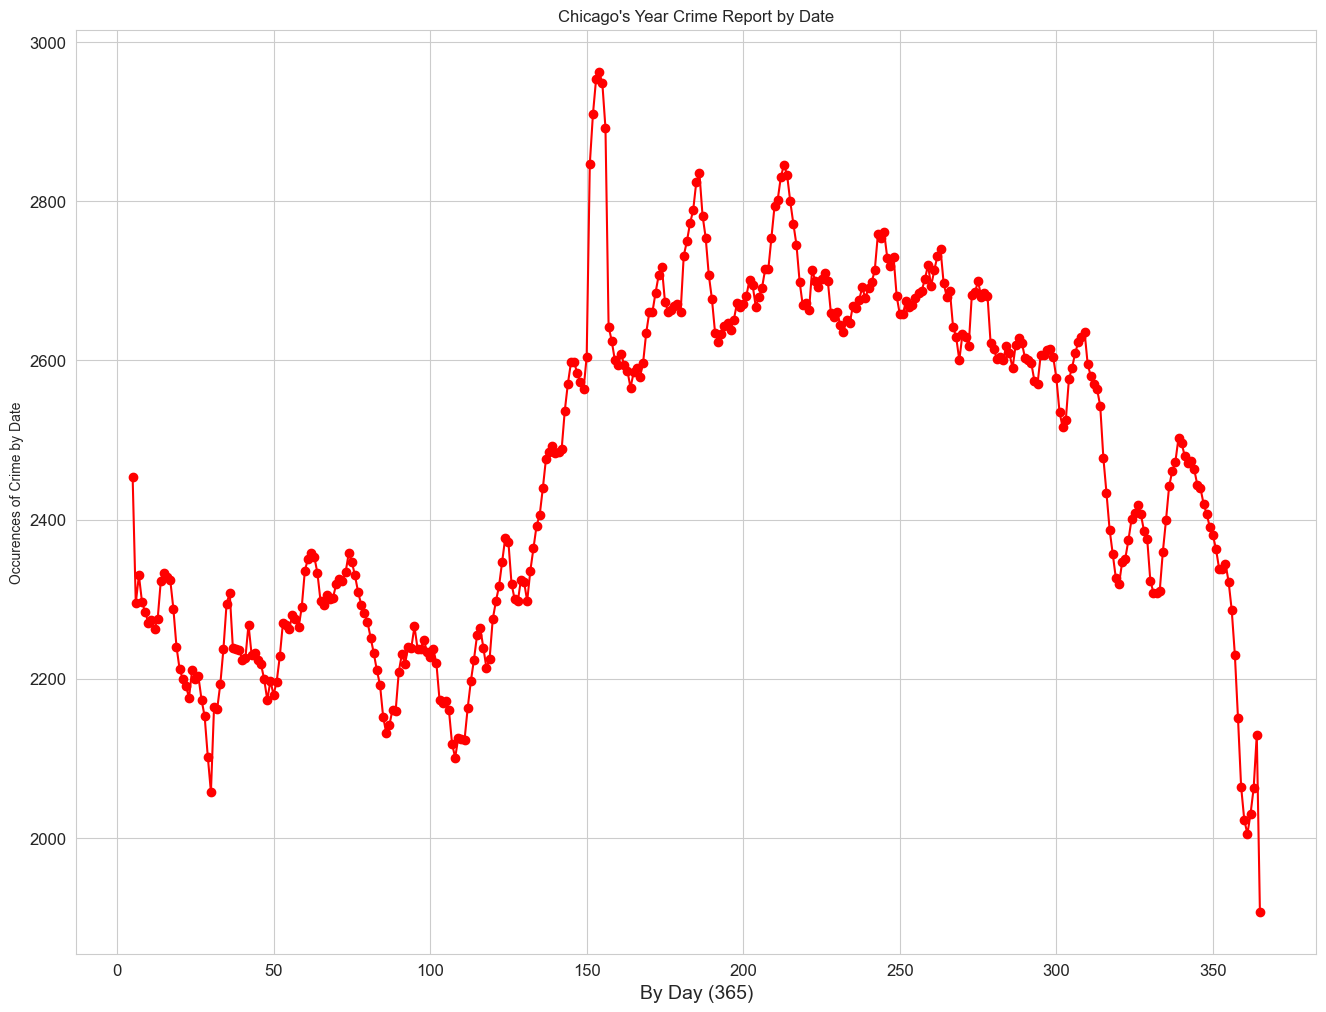

In [86]:
daily_crime_counts["Crime Count"]
plt.figure(figsize=(16,12))
rolling_mean = daily_crime_counts['Crime Count'].rolling(window=6).mean()
plt.plot(rolling_mean, color="red", label="Price", marker="o")
plt.xlabel("By Day (365)", fontsize=14)
plt.ylabel("Occurences of Crime by Date")
plt.title("Chicago's Year Crime Report by Date")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


In [87]:
daily_crime_counts['Crime Count Rolling Mean'] = daily_crime_counts['Crime Count'].rolling(window=6).mean()
daily_crime_counts['Crime Count Rolling Mean']
daily_crime_counts.isnull().sum()
daily_crime_counts.dropna(subset="Crime Count Rolling Mean")

,DayOfYear,Crime Count,Crime Count Rolling Mean
5,6,2281,2453.333333
6,7,2325,2295.166667
7,8,2317,2330.000000
8,9,2143,2296.166667
9,10,2293,2283.833333
...,...,...,...
361,362,2121,2004.833333
362,363,2274,2030.166667
363,364,2172,2062.500000
364,365,2231,2130.000000


In [90]:
daily_crime_counts = daily_crime_counts.dropna()

In [91]:
target_col = "Crime Count Rolling Mean"
from sklearn.preprocessing import MinMaxScaler
sc_data = MinMaxScaler(feature_range=(0,1))
sc_response = MinMaxScaler(feature_range=(0,1))

response_scaled = sc_response.fit_transform(daily_crime_counts[[target_col]])
data_set_scaled = sc_data.fit_transform(daily_crime_counts.loc[:, daily_crime_counts.columns != target_col])
print(data_set_scaled.shape)

data_set_scaled_new = []
for i in range(len(data_set_scaled)):
    data_set_scaled_new.append([])

    data_set_scaled_new[i] = np.append(data_set_scaled[i], response_scaled[i])
    # print(data_set_scaled_new[i])

data_set_scaled_new =np.asarray(data_set_scaled_new)
print(data_set_scaled_new)
#print(data_set_scaled_new.shape)

(361, 2)
[[0.         0.48863006 0.51729038]
 [0.00277778 0.50083195 0.36744039]
 [0.00555556 0.49861342 0.40044213]
 ...
 [0.99444444 0.45840266 0.14700774]
 [0.99722222 0.47476428 0.21095847]
 [1.         0.         0.        ]]


In [ ]:
## WORK ON FORECASTING 

In [ ]:
class LSTM(L.LightningModule):

    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

        self.wlr1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wlr2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.blr1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        self.wpr1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wpr2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bpr1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        self.wp1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wp2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bp1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        self.wo1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wo2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bo1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

    def lstm_unit(self, input_value, long_memory, short_memory):
        # make a forward pass through unrolled LSTM
        long_pct = torch.sigmoid((short_memory * self.wlr1) +
                                 (input_value * self.wlr2) +
                                 self.blr1) #bias coefficient
        
        potential_remember_percent = torch.sigmoid((short_memory * self.wpr1) +
                                      (input_value * self.wpr2) +
                                      self.bpr1)
        
        potential_memory = torch.tanh((short_memory * self.wp1) +
                                      (input_value * self.wp2) +
                                      self.bp1)
    
        updated_long_memory = ((long_memory * long_pct) +
                               (potential_remember_percent * potential_memory))
        
        output_pct = torch.sigmoid((short_memory * self.wo1) +
                                   (input_value * self.wo2) +
                                   self.bo1)
        
        updated_short_memory = torch.tanh(updated_long_memory) * output_pct

        # return updated long/short term memory trained
        return([updated_long_memory, updated_short_memory])
    
    def forward(self, input):
        # x shape: (batch_size, sequence_length, input_size)
        lstm_out, (hn, cn) = self.lstm(input)
        # Select the output of the last time step
        out = self.fc(lstm_out[:, -1, :])
        return out



    def configure_optimizers(self):
        # configure adam optimizer
        return optim.Adam(self.parameters(), lr=0.001)
    
    def trainining_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = nn.functional.mse_loss(output_i, label_i)
        self.log("train_loss", loss)
        return loss

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
#success

(7802, 7)
(1951, 7)
(7802,)
(1951,)
